In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fer2013/test/surprise/PublicTest_78686873.jpg
/kaggle/input/fer2013/test/surprise/PrivateTest_58522921.jpg
/kaggle/input/fer2013/test/surprise/PrivateTest_83796714.jpg
/kaggle/input/fer2013/test/surprise/PublicTest_84428313.jpg
/kaggle/input/fer2013/test/surprise/PrivateTest_87978901.jpg
/kaggle/input/fer2013/test/surprise/PrivateTest_90978621.jpg
/kaggle/input/fer2013/test/surprise/PrivateTest_27580582.jpg
/kaggle/input/fer2013/test/surprise/PublicTest_15760011.jpg
/kaggle/input/fer2013/test/surprise/PublicTest_49739228.jpg
/kaggle/input/fer2013/test/surprise/PublicTest_5351857.jpg
/kaggle/input/fer2013/test/surprise/PrivateTest_56096676.jpg
/kaggle/input/fer2013/test/surprise/PrivateTest_71692098.jpg
/kaggle/input/fer2013/test/surprise/PublicTest_64532931.jpg
/kaggle/input/fer2013/test/surprise/PublicTest_17886908.jpg
/kaggle/input/fer2013/test/surprise/PrivateTest_21410542.jpg
/kaggle/input/fer2013/test/surprise/PrivateTest_68745885.jpg
/kaggle/input/fer2013/test/surpr

In [2]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import imghdr
import tensorflow as tf
from PIL import Image
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight

from tensorflow import keras
from tensorflow.keras import layers, models, regularizers, optimizers
from tensorflow.keras.applications import VGG16, ResNet50V2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard, CSVLogger
from tensorflow.keras.layers import Convolution2D, Dense, MaxPooling2D, Dropout, BatchNormalization, Flatten, Activation, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.utils import plot_model

2024-06-22 17:00:50.695768: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-22 17:00:50.695865: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-22 17:00:50.824265: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Data Cleaning

In [4]:
# Define the list of acceptable image extensions
image_exts = ['jpeg', 'jpg', 'png']

# Path to the directory containing image classes and possibly other nested subdirectories
data_dir = '/kaggle/input/fer2013/train'

# Walk through all directories and files in the dataset
for root, dirs, files in os.walk(data_dir):
    for file in files:
        # Construct the path to the current file
        file_path = os.path.join(root, file)

        try:
            # Check the file type of the current file
            file_type = imghdr.what(file_path)

            # If the file extension is not in the allowed list, remove it
            if file_type not in image_exts:
                print(f'Image not in ext list {file_path}')
                os.remove(file_path)
            else:
                # Proceed to process the image if needed, for example, reading it with OpenCV
                img = cv2.imread(file_path)

        except Exception as e:
            # Print out the issue and the path of the problematic file
            print(f'Issue with file {file_path}. Error: {e}')
            # Optionally, remove files that cause exceptions
            os.remove(file_path)

# Data analysis

In [5]:
# Define a function to count the number of files (assumed to be images for this context) for each subdirectory in a given directory.
# The function returns a DataFrame with these counts, indexed by a specified set name (e.g., 'train' or 'test').
def count_files_in_subdirs(directory, set_name):
    # Initialize an empty dictionary to hold the count of files for each subdirectory.
    counts = {}

    # Iterate over each item in the given directory.
    for item in os.listdir(directory):
        # Construct the full path to the item.
        item_path = os.path.join(directory, item)

        # Check if the item is a directory.
        if os.path.isdir(item_path):
            # Count the number of files in the subdirectory and add it to the dictionary.
            counts[item] = len(os.listdir(item_path))

    # Convert the counts dictionary to a DataFrame for easy viewing and analysis.
    # The index of the DataFrame is set to the provided set name.
    df = pd.DataFrame(counts, index=[set_name])
    return df

# Paths to the training and testing directories.
train_dir = '/kaggle/input/fer2013/train'
test_dir = '/kaggle/input/fer2013/test'

# Count the files in the subdirectories of the training directory and print the result.
train_count = count_files_in_subdirs(train_dir, 'train')
print(train_count)

# Count the files in the subdirectories of the testing directory and print the result.
test_count = count_files_in_subdirs(test_dir, 'test')
print(test_count)

       surprise  fear  angry  neutral   sad  disgust  happy
train      3171  4097   3995     4965  4830      436   7215
      surprise  fear  angry  neutral   sad  disgust  happy
test       831  1024    958     1233  1247      111   1774


<Axes: >

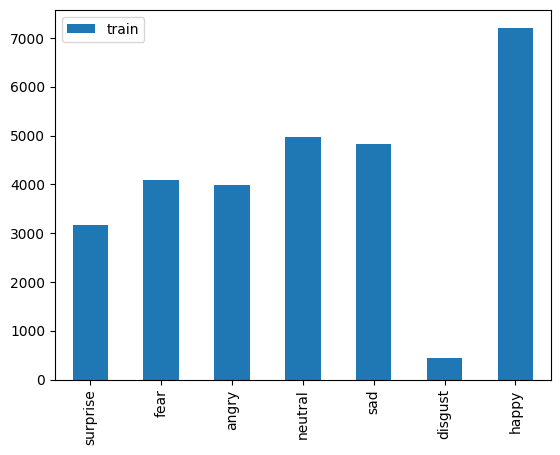

In [6]:
train_count.transpose().plot(kind='bar')

<Axes: >

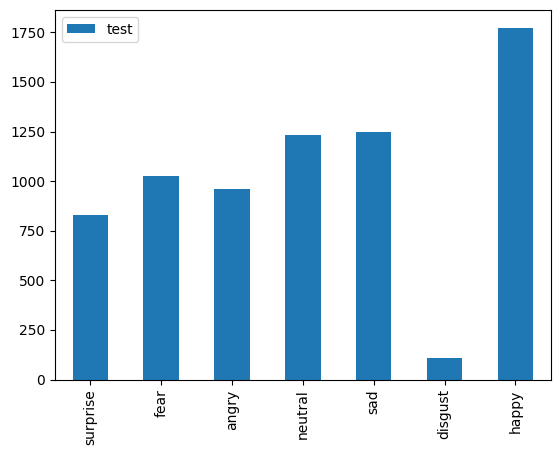

In [7]:
test_count.transpose().plot(kind='bar')

# Plotting one image from each emotion

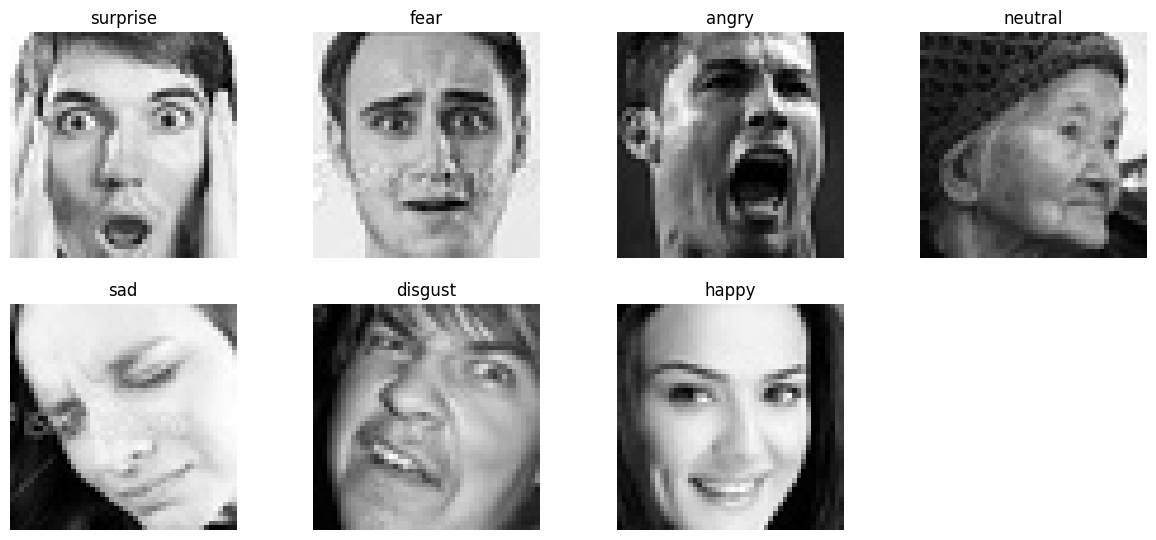

In [8]:
emotions = os.listdir(train_dir)
plt.figure(figsize=(15,10))

for i, emotion in enumerate(emotions, 1):
    folder = os.path.join(train_dir, emotion)
    img_path = os.path.join(folder, os.listdir(folder)[42])
    img = plt.imread(img_path)
    plt.subplot(3, 4, i)
    plt.imshow(img, cmap='gray')
    plt.title(emotion)
    plt.axis('off')

# Checking shapes and channels

In [9]:
image = '/kaggle/input/fer2013/train/happy/Training_16513509.jpg'

import cv2

img = cv2.imread(image, cv2.IMREAD_GRAYSCALE) # Default load in color format.

# If the image is loaded successfully, print its pixel values
if img is not None:
    # print(img)
    print("Shape:", img.shape)
else:
    print("The image could not be loaded. Please check the path and file permissions.")

Shape: (48, 48)


# Custom CNN model from Scratch

In [10]:
train_dir = '/kaggle/input/fer2013/train'
test_dir = '/kaggle/input/fer2013/test'

In [11]:
img_width, img_height = 48, 48
epochs = 10
batch_size = 64
num_of_classes = 7

In [12]:
data_generator = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_ds = data_generator.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size = batch_size,
    class_mode = 'categorical',
    color_mode = 'grayscale',
    subset = 'training'
)

validation_ds = data_generator.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size = batch_size,
    class_mode = 'categorical',
    color_mode = 'grayscale',
    subset = 'validation'
)

test_ds = data_generator.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size = batch_size,
    class_mode = 'categorical',
    color_mode = 'grayscale',
)

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [13]:
train_class_labels = train_ds.class_indices
print(f"Training class labels : {train_class_labels}")

validation_class_labels = validation_ds.class_indices
print(f"Validation class labels : {validation_class_labels}")

test_class_labels = test_ds.class_indices
print(f"Test class labels : {test_class_labels}")

Training class labels : {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
Validation class labels : {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
Test class labels : {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


In [14]:
model = Sequential()

model.add(Convolution2D(32, input_shape=(img_width, img_height, 1), kernel_initializer='glorot_uniform', kernel_size=(3,3), padding='same', activation='relu'))

model.add(Convolution2D(64, kernel_size=(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.25))

model.add(Convolution2D(128, kernel_regularizer=regularizers.l2(0.01), kernel_size=(3,3), padding='same', activation='relu'))

model.add(Convolution2D(256, kernel_regularizer=regularizers.l2(0.01), kernel_size=(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.25))

model.add(Convolution2D(512, kernel_regularizer=regularizers.l2(0.01), kernel_size=(3,3), padding='same', activation='relu'))

model.add(Convolution2D(512, kernel_regularizer=regularizers.l2(0.01), kernel_size=(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.25))

#Output layer
model.add(Dense(num_of_classes, activation='softmax'))

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [15]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 24, 24, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 12, 12, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │    18,875,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         7,175 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,813,703 (87.03 MB)

 Trainable params: 22,812,039 (87.02 MB)

 Non-trainable params: 1,664 (6.50 KB)

In [16]:
# Compiling the model

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy'])

# Callbacks

In [17]:
# File path for the model checkpoint
cnn_path = '/kaggle/working/'
name = 'Custom_CNN_model.keras'
chk_path = os.path.join(cnn_path, name)
chk_path

'/kaggle/working/Custom_CNN_model.keras'

In [18]:
# Callback to save the model checkpoint
checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             monitor='val_loss')

In [19]:
# Callback for early stopping
earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True)

In [20]:
# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=6,
                              verbose=1,
                              min_delta=0.0001)

In [21]:
# Callback to log training data to a CSV file
import os
from keras.callbacks import CSVLogger

# Define the base directory and subdirectory
base_dir = '/kaggle/working/'
cnn_path = os.path.join(base_dir, 'Custom_CNN_From_Scratch')

# Ensure the directory exists
os.makedirs(cnn_path, exist_ok=True)

# Create the CSVLogger callback
csv_logger = CSVLogger(os.path.join(cnn_path, 'training.log'))

In [22]:
# Aggregating all callbacks into a list
callbacks = [checkpoint, earlystop, reduce_lr, csv_logger]

In [23]:
print(callbacks)

[<keras.src.callbacks.model_checkpoint.ModelCheckpoint object at 0x79e5e6277700>, <keras.src.callbacks.early_stopping.EarlyStopping object at 0x79e5e6274250>, <keras.src.callbacks.reduce_lr_on_plateau.ReduceLROnPlateau object at 0x79e5e6277850>, <keras.src.callbacks.csv_logger.CSVLogger object at 0x79e6cfabadd0>]


# Calculating steps per epoch

In [24]:
training_steps_per_epoch = train_ds.samples // train_ds.batch_size + 1
validation_steps_per_epoch = validation_ds.samples // validation_ds.batch_size + 1
testing_steps_per_epoch = test_ds.samples // test_ds.batch_size + 1

In [25]:
training_steps_per_epoch

359

In [26]:
validation_steps_per_epoch

90

In [27]:
testing_steps_per_epoch

113

# Model training

In [28]:
# Ensure that all variables used in model.fit() are properly initialized
if train_ds is None:
    raise ValueError("Train dataset (train_ds) is None.")
if validation_ds is None:
    raise ValueError("Validation dataset (validation_ds) is None.")
if training_steps_per_epoch is None:
    raise ValueError("Training steps per epoch (training_steps_per_epoch) is None.")
if validation_steps_per_epoch is None:
    raise ValueError("Validation steps per epoch (validation_steps_per_epoch) is None.")
if callbacks is None:
    callbacks = []  # If callbacks is None, initialize it as an empty list

# Ensure that the model is compiled before calling model.fit()
if model.optimizer is None:
    raise ValueError("Model optimizer is not initialized. Model must be compiled before training.")

# Call model.fit() with proper error handling
history = model.fit(
    train_ds,
    steps_per_epoch=training_steps_per_epoch,
    epochs=10,
    validation_data=validation_ds,
    #validation_steps=validation_steps_per_epoch,
    callbacks=callbacks
)

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  2/359 ━━━━━━━━━━━━━━━━━━━━ 24s 70ms/step - accuracy: 0.1484 - loss: 16.0015   

I0000 00:00:1719075811.729189     102 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1719075811.750909     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


293/359 ━━━━━━━━━━━━━━━━━━━━ 7s 115ms/step - accuracy: 0.2562 - loss: 13.3114

W0000 00:00:1719075845.154037     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


358/359 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.2636 - loss: 13.1157

W0000 00:00:1719075850.040720     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_loss improved from inf to 16.12506, saving model to /kaggle/working/Custom_CNN_model.keras


W0000 00:00:1719075858.678779     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


359/359 ━━━━━━━━━━━━━━━━━━━━ 72s 134ms/step - accuracy: 0.2638 - loss: 13.1100 - val_accuracy: 0.1106 - val_loss: 16.1251 - learning_rate: 1.0000e-04
Epoch 2/10


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_loss improved from 16.12506 to 16.12506, saving model to /kaggle/working/Custom_CNN_model.keras
359/359 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.1106 - val_loss: 16.1251 - learning_rate: 1.0000e-04
Epoch 3/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.3821 - loss: 10.0375
Epoch 3: val_loss improved from 16.12506 to 8.55193, saving model to /kaggle/working/Custom_CNN_model.keras
359/359 ━━━━━━━━━━━━━━━━━━━━ 26s 72ms/step - accuracy: 0.3821 - loss: 10.0358 - val_accuracy: 0.4264 - val_loss: 8.5519 - learning_rate: 1.0000e-04
Epoch 4/10

Epoch 4: val_loss improved from 8.55193 to 8.55193, saving model to /kaggle/working/Custom_CNN_model.keras
359/359 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.4264 - val_loss: 8.5519 - learning_rate: 1.0000e-04
Epoch 5/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.4306 - loss: 7.6646
Epoch 5: val_loss improved from

In [29]:
model.save("Custom_CNN_From_Scratch_Model.keras")

# Plotting the performance metrics

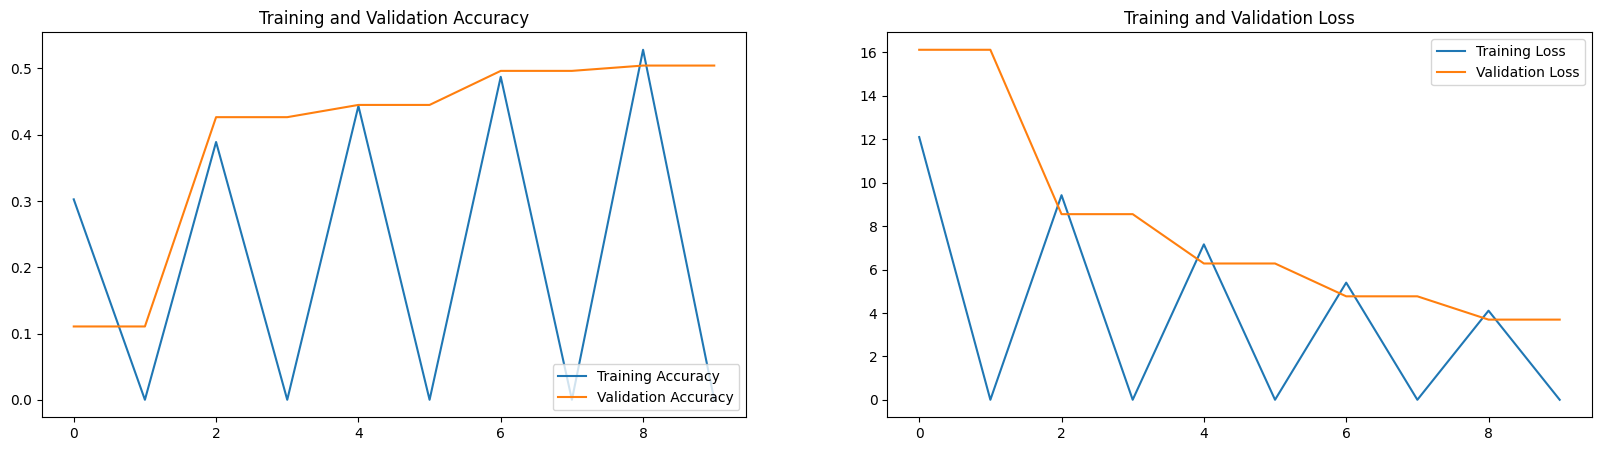

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(20, 5))

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show();

# Model evaluation

In [31]:
train_loss, train_acc = model.evaluate(train_ds)
test_loss, test_acc = model.evaluate(test_ds)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_acc*100, test_acc*100))

359/359 ━━━━━━━━━━━━━━━━━━━━ 21s 58ms/step - accuracy: 0.5672 - loss: 3.5199


W0000 00:00:1719076014.804869     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


113/113 ━━━━━━━━━━━━━━━━━━━━ 24s 215ms/step - accuracy: 0.5229 - loss: 3.6530
final train accuracy = 56.86 , validation accuracy = 51.62


W0000 00:00:1719076039.482850     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


# Plotting confusion matrix

  5/113 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step

W0000 00:00:1719076041.156662     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


113/113 ━━━━━━━━━━━━━━━━━━━━ 7s 54ms/step


W0000 00:00:1719076047.223640     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


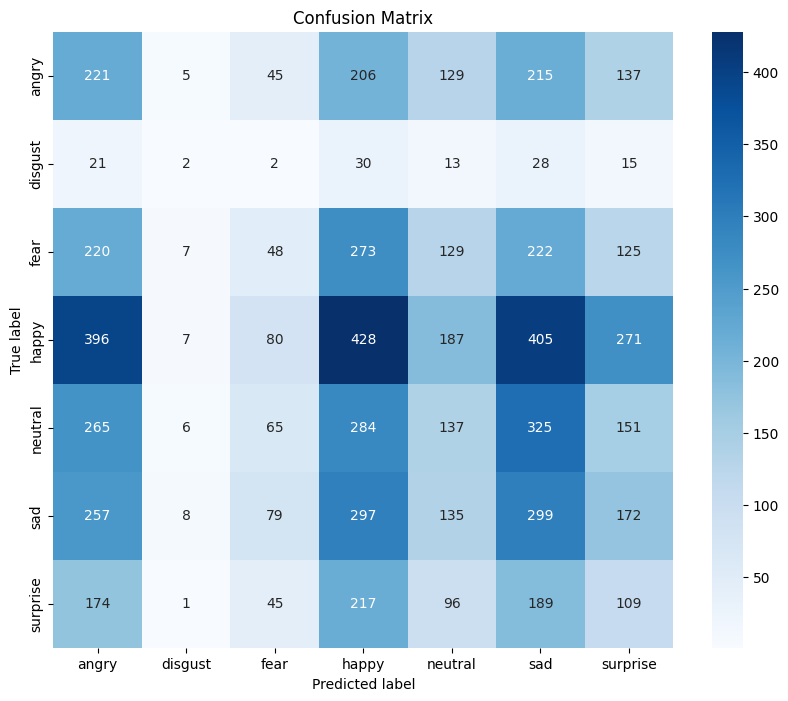

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming your true_classes and predicted_classes are already defined
true_classes = test_ds.classes
predicted_scores = model.predict(test_ds)
predicted_classes = np.argmax(predicted_scores, axis=1)
class_labels = list(test_ds.class_indices.keys())

# Generate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plotting with seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [33]:
# Printing the classification report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

       angry       0.14      0.23      0.18       958
     disgust       0.06      0.02      0.03       111
        fear       0.13      0.05      0.07      1024
       happy       0.25      0.24      0.24      1774
     neutral       0.17      0.11      0.13      1233
         sad       0.18      0.24      0.20      1247
    surprise       0.11      0.13      0.12       831

    accuracy                           0.17      7178
   macro avg       0.15      0.15      0.14      7178
weighted avg       0.17      0.17      0.17      7178

